In [ ]:
# !pip yfinance -q

ERROR: unknown command "yfinance"


In [710]:
import yfinance as yf
import random 
import numpy as np
import pandas as pd
import random
import numpy as np
from collections import deque, namedtuple
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from tqdm import tqdm
import os
import gc
from matplotlib import pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
%matplotlib inline


### **Stock Indicators**

In [814]:
def technical_indicators(df):
  df['Volume']=df['Volume']/1000000
  df_close=df['Close']
  df_close=pd.DataFrame(df_close, columns=['Close'])
  df11=df_close.reset_index()
  #RSI
  df11['change'] = df11['Close'].diff()
  df['change']=df11['change']
    #SMA  #10days
  df['SMA10'] = df11['Close'].rolling(10).mean()
    #EMA
  df11['EWMA30'] = df11['Close'].ewm(span=10).mean()

  # df['delta']=(df['change']>0)*1.
  def rma(x, n):
      """Running moving average"""
      a = np.full_like(x, np.nan)
      a[n] = x[1:n+1].mean()
      for i in range(n+1, len(x)):
          a[i] = (a[i-1] * (n - 1) + x[i]) / n
      return a

  df11['gain'] = df11.change.mask(df11.change < 0, 0.0)
  df11['loss'] = -df11.change.mask(df11.change > 0, -0.0)
  df11['avg_gain'] = rma(df11.gain.to_numpy(), 14)        
  df11['avg_loss'] = rma(df11.loss.to_numpy(), 14)     
  df11['rs'] = df11.avg_gain / df11.avg_loss
  df11['rsi'] = 100 - (100 / (1 + df11.rs))

   #stochastic oscillator
  df['14-high'] = df['High'].rolling(14).max()
  df['14-low'] = df['Low'].rolling(14).min()
  df['%K'] = (df['Close'] - df['14-low'])*100/(df['14-high'] - df['14-low'])
  df['%D'] = df['%K'].rolling(3).mean() 

  #MACD
  k = df['Close'].ewm(span=12, adjust=False, min_periods=12).mean()
  d = df['Close'].ewm(span=26, adjust=False, min_periods=26).mean()
  macd = k - d
  macd_s = macd.ewm(span=9, adjust=False, min_periods=9).mean()
  macd_h = macd - macd_s

  df['macd'] = df.index.map(macd)
  df['macd_h'] = df.index.map(macd_h)
  df['macd_s'] = df.index.map(macd_s)
    #A/D
  df['cmfv'] = ((df['Close']-df['Low'])-(df['High']-df['Close']))/df['High']-df['Low']*df['Volume']
  df['A/D'] = df['cmfv'].cumsum()

    #OBV
  df['obv'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
  #ROC
  N=df['Close'].diff(13)
  D=df['Close'].shift(13)
  df['ROC'] = pd.Series(100*N/D)

  #william R
  highh = df['High'].rolling(14).max() 
  lowl = df['Low'].rolling(14).min()
  df['wr'] = -100 * ((highh - df['Close']) / (highh - lowl))

  #disparity index
  ma = df['Close'].rolling(14).mean()
  df['disparity'] = ((df['Close'] - ma) / ma) * 1000


  df11.drop(columns=['Close','change','index','gain','loss','avg_gain','avg_loss','rs'], inplace=True)
  df_cat=pd.concat([df, df11], axis=1)
  df_cat.fillna(method='bfill', axis=0, inplace=True)
  df_cat.fillna(method='ffill', axis=0, inplace=True)
  return df_cat

dir=["AAPL"]
dfs=[]
for i in range(len(dir)):
  Stock = pd.read_csv(dir[i]+".csv")
  USED_LENGTH=int(0.5*len(Stock))
  Stock = (Stock.iloc[USED_LENGTH:]).reset_index()    #only use generate prediction
  df=technical_indicators(Stock).drop(columns=['Date','Adj Close','index'])
  dfs.append(df)


print("Used length", USED_LENGTH)
assert(len(dfs)==len(dir))

FEATURE=dfs[0].shape[-1]
print(FEATURE)
print(dfs[0].columns)
dfs[0]


Used length 1676
22
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'change', 'SMA10', '14-high',
       '14-low', '%K', '%D', 'macd', 'macd_h', 'macd_s', 'cmfv', 'A/D', 'obv',
       'ROC', 'wr', 'disparity', 'EWMA30', 'rsi'],
      dtype='object')


,Open,High,Low,Close,Volume,change,SMA10,14-high,14-low,%K,...,macd_h,macd_s,cmfv,A/D,obv,ROC,wr,disparity,EWMA30,rsi
0,26.450001,26.625000,26.375000,26.500000,99.4556,0.025000,26.616500,29.045000,25.632500,80.952381,...,0.061421,0.440894,-2623.141450,-2.623141e+03,0.0000,7.150943,-19.047619,45.787575,26.500000,67.134431
1,26.415001,26.642500,26.410000,26.525000,118.6496,0.025000,26.616500,29.045000,25.632500,80.952381,...,0.061421,0.440894,-3133.536030,-5.756677e+03,118.6496,7.150943,-19.047619,45.787575,26.513750,67.134431
2,26.535000,26.700001,26.405001,26.682501,106.8060,0.157501,26.616500,29.045000,25.632500,80.952381,...,0.061421,0.440894,-2820.202799,-8.576880e+03,225.4556,7.150943,-19.047619,45.787575,26.581587,67.134431
3,26.924999,27.000000,26.705000,26.932501,107.2100,0.250000,26.616500,29.045000,25.632500,80.952381,...,0.061421,0.440894,-2863.037124,-1.143992e+04,332.6656,7.150943,-19.047619,45.787575,26.697197,67.134431
4,26.975000,27.075001,26.877501,26.924999,107.5216,-0.007502,26.616500,29.045000,25.632500,80.952381,...,0.061421,0.440894,-2889.915697,-1.432983e+04,225.1440,7.150943,-19.047619,45.787575,26.762593,67.134431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1672,165.000000,165.600006,163.889999,165.330002,41.9496,0.309998,164.800002,168.160004,159.779999,66.229113,...,-0.260908,3.000341,-6875.112837,-1.527152e+07,6815.6364,-0.181128,-33.770887,4.574498,165.053623,59.225082
1673,165.190002,166.309998,163.729996,163.770004,48.7141,-1.559998,165.097002,168.160004,159.779999,47.613396,...,-0.432403,2.892241,-7975.974430,-1.527950e+07,6766.9223,0.006112,-52.386604,-4.100374,164.820238,54.771877
1674,163.059998,165.279999,162.800003,163.759995,45.4988,-0.010009,165.463001,168.160004,159.779999,47.493957,...,-0.544232,2.756183,-7407.208165,-1.528691e+07,6721.4235,-0.546586,-52.506043,-4.161239,164.627466,54.743436
1675,165.190002,168.559998,165.190002,168.410004,64.9023,4.650009,165.748001,168.559998,159.779999,98.291640,...,-0.314170,2.677640,-10721.192854,-1.529763e+07,6786.3258,3.937546,-1.708360,22.450438,165.315200,64.076414


In [815]:
#Normalize time series
# Scalers = [ StandardScaler() for _ in range(len(dfs)) ]
dfs_standard=[]
for i in range(len(dfs)):
  dataset_standard = dfs[i]#Scalers[i].fit_transform(dfs[i])
  dfs_standard.append(dataset_standard)

print(dfs_standard[0].shape)

(1677, 22)


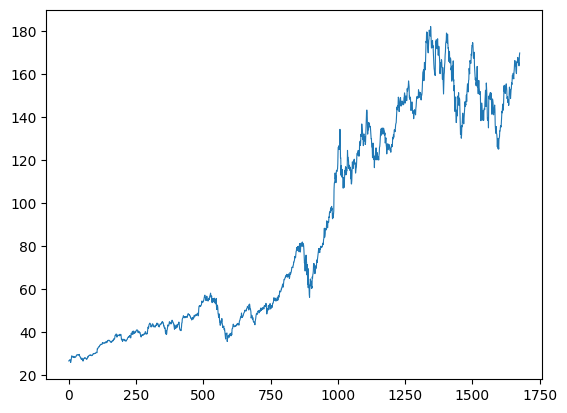

In [816]:
stock_price_array=np.array(dfs_standard[0])[:,3]   #Price   3
plt.plot(stock_price_array, linewidth=0.8)

# plt.annotate("AAPL",xy=(0,30),textcoords='offset points', fontsize=20)

In [817]:
stock_price_array=np.array(dfs_standard[0])[:,3]
stock_array=np.array(dfs_standard[0])
print(stock_array.shape)

(1677, 22)


### **Train Test Split**

1006
X_train length 1006
X_test length 671


<ipython-input-818-c1aa4a35eb3e>:17: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  plt.annotate("AAPL",xy=(0,20),textcoords='offset points', fontsize=20)


Text(0, 20, 'AAPL')

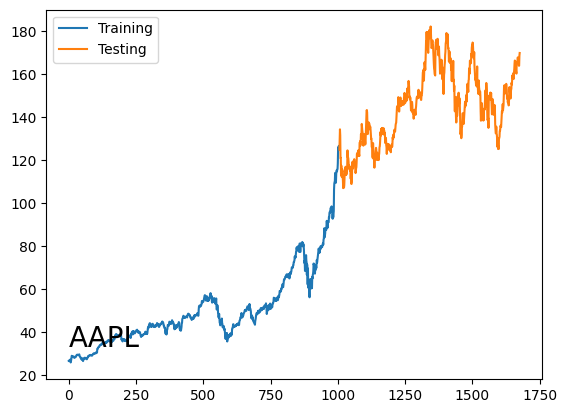

In [818]:
used_length=int(len(stock_array)*0.6)

stock_price_train=stock_price_array[:used_length]
stock_train=stock_array.copy()[:used_length]

stock_price_test=stock_price_array[used_length:]
stock_test=stock_array[used_length:]

print(used_length)

print("X_train length", len(stock_train))
print("X_test length", len(stock_test))

plt.plot(stock_price_train,label='Training')
plt.plot(np.arange(len(stock_price_train),len(stock_array)),stock_price_test, label='Testing')
plt.legend()
plt.annotate("AAPL",xy=(0,20),textcoords='offset points', fontsize=20)

### **Use Transformer Generated Prediction**

In [819]:
stock_train.shape

(1006, 22)

In [820]:
transformer_pred = np.array(pd.read_csv("AAPL_Pred.csv"))[USED_LENGTH:, 1:]
print(transformer_pred.shape)
transformer_pred_train=transformer_pred[:used_length]
transformer_pred_test=transformer_pred[used_length:]

print("pred train len",transformer_pred_train.shape)
print("pred test len",transformer_pred_test.shape)

(1677, 7)
pred train len (1006, 7)
pred test len (671, 7)


### **Visualize Actual & Prediction**

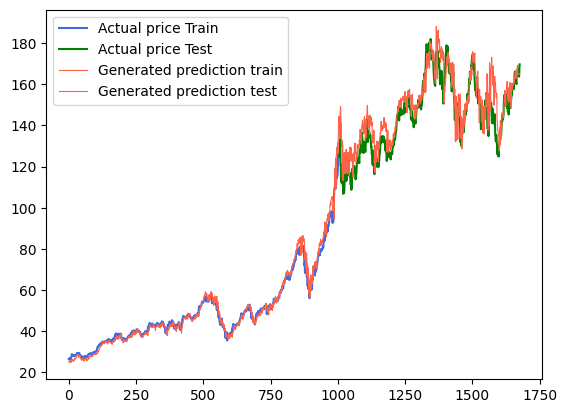

In [821]:
plt.plot(stock_price_train,label='Actual price Train', color='royalblue')
plt.plot(np.arange(len(stock_price_train),len(stock_price_train)+len(stock_price_test)),stock_price_test,label='Actual price Test', color='green')
plt.plot(transformer_pred_train[:,0], label='Generated prediction train',linewidth=0.8, color='tomato')
plt.plot(np.arange(len(stock_price_train),len(stock_price_train)+len(stock_price_test)),transformer_pred_test[:,0], label='Generated prediction test',linewidth=0.8, color='tomato')
plt.legend()

In [822]:
stock_price_train.max()

126.522499

In [823]:
transformer_pred[0]   #each day we have a window of prediction of next 7 days

array([25.217367, 25.249771, 25.186594, 25.253185, 25.226475, 25.187412,
       25.199465])

### **Create Trading Game**

In [824]:
TRANSACTION=0.0001
CONTEXT=30
LOOK_FORWARD=7
class Game:  # Create tradin game step day by day through the stock, look at a window of prices, and try to make actions at each timestep
    def __init__(self, w=CONTEXT, stock=stock_train, stock_price=stock_price_train, transformer_pred=transformer_pred_train):
        self.w = w #window size
        self.stock=stock
        self.stock_price=stock_price
        self.transformer_pred=transformer_pred
        self.reset() 

    def reset(self):
        # restart game, initialize game state
        self.money=1000000 
        self.positions=10000   # shares holding

        self.today=CONTEXT-LOOK_FORWARD-1      #30- 7-1   =22           0~22,      22 ,     23~29
        self.inital_property=self.positions*self.stock_price[self.today]+self.money  #initial total investment = 10,000 shares + cash

        
        self.window_right=self.w-1   #29
        self.window_left=0         
        
        self.today_price = self.stock_price[self.today]        
        self.window = self.stock_price[ self.window_left:self.today+1] #price    0~14

        self.window_all=self.stock[ self.window_left:self.today+1]  #22 features
        
        self.previous_reward=0  #to store and plot the mean reward during each game to see if improves
        self.yesterday_property= self.inital_property
        self.profit=0 
        
        
        self.money_record=[self.money]*CONTEXT
        self.positions_record=[self.positions]*CONTEXT

        self.money_window=self.money_record[self.window_left:self.today+1]
        self.positions_window=self.positions_record[self.window_left:self.today+1]

        self.window_pred=self.transformer_pred[self.today]   # transformer predictions

        
    def play_step(self, action):
        self.yesterday_price=self.money
        self.yesterday_property=(self.money + self.today_price*self.positions )

        # 2. make a move, compute money, update positions
        self.money=self.money - self.today_price * action
         #update positions
        self.positions += action     #shares in hand

        self.money_record.append(self.money)
        self.positions_record.append(self.positions)

        self.today += 1  # update the head and window
        self.today_price=self.stock_price[self.today] 
        #move window forward
        self.window_left += 1 
        self.window_right += 1 

        self.window=self.stock_price[self.window_left:self.today+1]       #past prices

        self.window_all=self.stock[self.window_left:self.today+1]         #past indicators

        self.window_pred=self.transformer_pred[self.today+1]   # transformer predictions


        self.money_window=self.money_record[self.window_left:self.today+1]
        self.positions_window=self.positions_record[self.window_left:self.today+1]


        # 3. check if game over
        game_over = False

        if self.is_collision():
            
            game_over = True
            reward = (self.money + self.today_price*self.positions ) - self.yesterday_property      -  abs(action)*TRANSACTION
            # reward/=10
            reward = reward+ 20*(self.window_pred.mean() - self.window_pred[0]) * action
            #calculate profit at the end of each game
            self.profit= ((self.money + self.today_price*self.positions )-self.inital_property) /self.inital_property  #profitability at the end of each game
            
            return reward, game_over

        #the reward function will be defined as the difference between the portfolio value 
        #at the end of the time step and the portfolio value at the beginning of the time step.

        reward= (self.money + self.today_price*self.positions ) - self.yesterday_property            -  abs(action)*TRANSACTION
        # reward/=10
        
        # print("curriculum",0.1*(self.right_mean-self.left_mean)*action 
        reward= reward+ 20*(self.window_pred.mean()- self.window_pred[0]) * action 
                #curriculum1: if right mean > left mean, and you buy today, then reward the agent, vice versa for sell
                
        return reward, game_over


    def is_collision(self):
        # hits boundary 
        if self.window_right>len(self.stock_price)-2:
            return 1
        return 0


In [825]:
stock_train.shape

(1006, 22)

### **Define State, Action Space**

In [826]:
STATE_SIZE=2+ stock_train.shape[-1] #prices in window + position and money in hand
print("State size:", STATE_SIZE)  # state size is of length CONTEXT  * customized dimensions 
ACTION_SPACE=np.arange(-2000,2001,400).tolist()    #actions
ACTION_SIZE=len(ACTION_SPACE)
print("Action_size:", ACTION_SIZE)
print("Action_space:", ACTION_SPACE)

State size: 24
Action_size: 11
Action_space: [-2000, -1600, -1200, -800, -400, 0, 400, 800, 1200, 1600, 2000]


### **Build Double Q leaning**

In [827]:
MAX_MEMORY = 10000 # record 40000 state, action, reward, next_state, done tuples
BATCH_SIZE = 512
criterion = nn.SmoothL1Loss()
LR = 0.001
GAMMA=0.999
TAU=0.5
Q_UPDATE_FREQ=20
#Qnet for a given state action pair gives value
class QNetwork(nn.Module):
    def __init__(self, state_size=STATE_SIZE, action_size=ACTION_SIZE, hidden_size=256):
        super(QNetwork, self).__init__()
        self.embedding=nn.Sequential(
        nn.Conv1d(state_size, hidden_size, kernel_size=5, stride=1, padding=2, bias=False ),
        nn.GELU(),
        nn.BatchNorm1d(hidden_size),

        nn.Conv1d(hidden_size, hidden_size, kernel_size=3, stride=1, padding=1, bias=False ),
        nn.BatchNorm1d(hidden_size),
        )

        self.fc=nn.Sequential(
            
        nn.Linear(hidden_size, hidden_size),
        nn.GELU(),
        nn.Linear(hidden_size, hidden_size),
        nn.GELU(),
        nn.Linear(hidden_size, hidden_size),
        nn.GELU()
        )
        self.Linear_out=nn.Linear(hidden_size * CONTEXT, action_size)
    def forward(self, x):
        #batch * feature * length 
        out=self.embedding(torch.transpose(x,1,2))  
        out=self.fc(torch.transpose(out,1,2))

        out=self.Linear_out(    out.flatten(1)   )
        return out

class DoubleDQN:
    def __init__(self, state_size=STATE_SIZE, action_size=ACTION_SIZE, hidden_size=256, lr=LR, tau=TAU,
                 q_update_freq=Q_UPDATE_FREQ, 
                 ):
        self.q_net = QNetwork(state_size, action_size, hidden_size)
        self.target_q_net = QNetwork(state_size, action_size, hidden_size)
        self.target_q_net.load_state_dict(self.q_net.state_dict())

        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)
        self.tau = tau
        self.total_steps=0
        self.q_update_freq=q_update_freq

    def soft_update(self):
        if self.total_steps % self.q_update_freq==0:
          for target_param, param in zip(self.target_q_net.parameters(), self.q_net.parameters()):
              target_param.data.copy_(self.tau * param.data + (1-self.tau) * target_param.data)

    def train_step(self, state, action, reward, next_state, done):
      self.total_steps += 1

      states_tensor = torch.FloatTensor(state)  #batch_size * state_size 
      actions_tensor = torch.LongTensor(action)  #batch_size
      rewards_tensor = torch.FloatTensor(reward) #batch_size
      next_states_tensor = torch.FloatTensor(next_state)  #batch_size * state_size 
      dones_tensor = torch.BoolTensor(done)  #batch_size

      with torch.no_grad():
        q_next=self.target_q_net(next_states_tensor) #use 2-Qnet to estimate target Q
        max_q_next,_ = torch.max(q_next, dim=1)
        q_target = rewards_tensor + GAMMA * max_q_next * (~dones_tensor)

      q_pred = self.q_net(states_tensor)    #use 1-Qnet to get current Q rped
      actions_index=[]
      for b in range(BATCH_SIZE):
        actions_index.append(ACTION_SPACE.index(actions_tensor[b]))
      actions_index=torch.tensor(actions_index, dtype=torch.int64)

      q_values_pred_selected = q_pred.gather(1, actions_index.unsqueeze(1)).squeeze(1)

      loss = criterion(q_values_pred_selected, q_target) /(BATCH_SIZE)           

      self.optimizer.zero_grad()
      loss.backward()
      torch.nn.utils.clip_grad_norm_(self.q_net.parameters(), 1e+8)
      self.optimizer.step()

      self.soft_update()

      return loss.item()

### **Create Agent that play the game and sample experiences to train**

In [828]:
class Agent:
    def __init__(self):
        self.n_games = 0
        self.trainer = DoubleDQN() 
        self.memory = deque(maxlen=MAX_MEMORY) # a collection of past experiences 

    def get_state(self, game):

        window_all=np.array(game.window_all )
        money_window=(np.array(game.money_window)/10000).reshape(-1,1)   #your money
        positions_window=(np.array(game.positions_window)/100).reshape(-1,1)
        
        pred_window = np.array(game.window_pred ).reshape(-1,1)

        assert(game.money>=0.0)
        assert(game.positions>=0.0)

        state= np.concatenate( [positions_window, money_window, window_all], axis=-1  ) # 23, 24

        pred_window_repeat=np.repeat(pred_window, state.shape[-1], axis=-1)   #7, 24

        state=np.concatenate([state, pred_window_repeat], axis=0)   #30, 24

        return state

    def remember(self, state, action, reward, next_state, done):
        # state=(state- np.mean(state,axis=0))/np.std(state,axis=0) #normalize
        reward/=100
        self.memory.append((state, action, reward, next_state, done)) # popleft if MAX_MEMORY is reached


    def train_batch_experience(self):

        if len(self.memory) >= BATCH_SIZE:
            batch_sample = random.sample(self.memory, BATCH_SIZE)  # list of tuples
            #pass in batch to train
            states, actions, rewards, next_states, dones = zip(*batch_sample)
            # print("states", states.shape)
            loss=self.trainer.train_step(states, actions, rewards, next_states, dones)
            return loss
        return 0.
            
    def get_action(self, state, game):    # e p s i l o n greedy---------------------------------------------------------------------------------
        #80% possibility of taking random action. decrease in time
        self.epsilon = 100 - self.n_games//2   #2 games reduce 1% chance of choosing action other than the best action
        if self.epsilon<6:
          self.epsilon=6 #not allowing below 10%  randomness
        position=game.positions
        money=game.money

        today_price=game.today_price

        final_move=0.
        #explore random actions
        if random.randint(0, 100) < max(self.epsilon,0) or (len(self.memory) <= BATCH_SIZE):
            actions=np.array(ACTION_SPACE)
            final_move=np.random.choice(actions)  
            #cannot buy more than the money you have, find closest value in the action space
            if final_move>0 and final_move*today_price >= money:
              for a in reversed(ACTION_SPACE): # find action that doesn't use up all your money in action space
                if a>=0 and a*today_price < money:
                  return a
              
            if final_move<0 and final_move<-position:    
              for a in ACTION_SPACE:  #find action that doesn't sell all your shares in action space
                if a<=0 and a+position>=0:
                  return a

        #take max q action
        else:
            state_input = torch.tensor(state, dtype=torch.float).unsqueeze(0)
            # print("QpredstateL",state_input.shape)
            Q_pred= self.trainer.q_net(state_input)
            move = torch.argmax(Q_pred).item() # 
            #allowable=np.clip(move, -position, money//today_price)    
            final_move=ACTION_SPACE[move]
            
            #cannot buy more than the money you have, find closest value in the action space
            if final_move>0 and final_move*today_price > money:
              for a in reversed(ACTION_SPACE):
                if a>=0 and a*today_price< money: #find action that doesn't use up all your money in action space
                  # print("action", a, today_price, money)
                  return a
            
            if final_move<0 and final_move<-position:   
              for a in ACTION_SPACE: #find action that doesn't sell all your shares in action space
                if a<=0 and a+position>=0:
                  return a

        if final_move>0 and final_move*today_price >= money:
          # print("action", a, today_price, money)
          return 0.
        if final_move<0 and final_move<-position:
          return 0.

        return final_move

actions=[]
plot_profit=[]
plot_reward=[]
plot_loss=[]
agent = Agent()
def train():
    rewards = []
    record = 0
    game = Game(w=CONTEXT, stock=stock_train, stock_price=stock_price_train, transformer_pred=transformer_pred_train)
    epoch=200000 #a very large number just to keep the game running
    optimizer=agent.trainer.optimizer
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=stock_price_train.shape[0]*3, gamma=0.995)
    for i in tqdm( range(1,epoch+1) ):
        
        curr_lr = float(optimizer.param_groups[0]['lr'])
        state_old = agent.get_state(game)
        action = agent.get_action(state_old, game)
        actions.append(action)
        
        reward, done= game.play_step(action)
#--------------------------------------------------------------------------------------------------------------------
        state_new = agent.get_state(game)
        # memory stored for replay
        agent.remember(state_old, action, reward, state_new, done)
        #loss=agent.train_single_experience(state_old, action, reward, state_new, done)

          
        rewards.append(reward)
        profit=game.profit

        if done:
            mean_reward=np.mean(rewards)
            plot_reward.append(mean_reward)
            rewards=[]
            # train minibatch
            loss=agent.train_batch_experience()
            plot_loss.append(loss)
            game.reset()
            agent.n_games += 1
            
            if profit > record:
                record = profit
               # agent.model.save()


            print('Game', agent.n_games,"mean Reward", round(mean_reward,2), 'Profit', round(profit*100,2) ,'Record:', round(record*100,2), "eps",agent.epsilon,"lr",round(curr_lr,6), "loss", round(loss,6))

            plot_profit.append(profit)
        scheduler.step()


In [829]:
# from google.colab import drive
# drive.mount('/content/drive')

In [830]:
# PATH = "/content/drive/MyDrive/checkpoint01"
# torch.save(agent.trainer.q_net.state_dict(), PATH)

In [831]:
gc.collect()
torch.cuda.empty_cache()

### **Train and see Rewards and Profits**

In [832]:
train()
#profit is the percentage of cumulated money through the money over money that I had in hand before the game
#mean reward is the average daily dollar returns in each game

  0%|          | 0/200000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
  1%|          | 1370/200000 [00:02<06:10, 536.63it/s]

Game 1 mean Reward 3602.96 Profit 186.95 Record: 186.95 eps 100 lr 0.001 loss 0.407626


  1%|▏         | 2604/200000 [00:04<05:35, 588.37it/s]

Game 2 mean Reward 2061.03 Profit 129.57 Record: 186.95 eps 100 lr 0.001 loss 0.381173


  2%|▏         | 3506/200000 [00:06<05:09, 633.99it/s]

Game 3 mean Reward 787.89 Profit 73.5 Record: 186.95 eps 99 lr 0.001 loss 0.342816


  2%|▏         | 4307/200000 [00:08<05:24, 603.64it/s]

Game 4 mean Reward 2065.57 Profit 157.83 Record: 186.95 eps 99 lr 0.000995 loss 0.357476


  3%|▎         | 5569/200000 [00:09<04:50, 670.34it/s]

Game 5 mean Reward 3263.49 Profit 199.05 Record: 199.05 eps 98 lr 0.000995 loss 0.386069


  3%|▎         | 6278/200000 [00:11<05:35, 578.20it/s]

Game 6 mean Reward 1879.78 Profit 161.68 Record: 199.05 eps 98 lr 0.000995 loss 0.329484


  4%|▎         | 7319/200000 [00:13<05:08, 625.27it/s]

Game 7 mean Reward 1982.29 Profit 183.81 Record: 199.05 eps 97 lr 0.00099 loss 0.354589


  4%|▍         | 8115/200000 [00:15<08:44, 365.79it/s]

Game 8 mean Reward 2197.98 Profit 163.03 Record: 199.05 eps 97 lr 0.00099 loss 0.31129


  5%|▍         | 9185/200000 [00:17<07:11, 442.41it/s]

Game 9 mean Reward 1680.41 Profit 138.75 Record: 199.05 eps 96 lr 0.00099 loss 0.338342


  5%|▌         | 10132/200000 [00:19<06:23, 494.54it/s]

Game 10 mean Reward 1907.19 Profit 165.71 Record: 199.05 eps 96 lr 0.000985 loss 0.342141


  6%|▌         | 11337/200000 [00:21<05:21, 587.15it/s]

Game 11 mean Reward 3819.26 Profit 284.39 Record: 284.39 eps 95 lr 0.000985 loss 0.404994


  6%|▌         | 12292/200000 [00:23<05:21, 584.29it/s]

Game 12 mean Reward 1877.3 Profit 199.88 Record: 284.39 eps 95 lr 0.000985 loss 0.373893


  7%|▋         | 13295/200000 [00:25<05:32, 561.56it/s]

Game 13 mean Reward 3825.03 Profit 199.8 Record: 284.39 eps 94 lr 0.00098 loss 0.375102


  7%|▋         | 14034/200000 [00:27<07:11, 430.55it/s]

Game 14 mean Reward 2243.09 Profit 189.45 Record: 284.39 eps 94 lr 0.00098 loss 0.358775


  7%|▋         | 14967/200000 [00:29<08:40, 355.56it/s]

Game 15 mean Reward 1804.5 Profit 206.53 Record: 284.39 eps 93 lr 0.00098 loss 0.362524


  8%|▊         | 16010/200000 [00:31<06:43, 456.22it/s]

Game 16 mean Reward 2726.93 Profit 253.77 Record: 284.39 eps 93 lr 0.000975 loss 0.39375


  8%|▊         | 16950/200000 [00:33<06:43, 453.24it/s]

Game 17 mean Reward 2359.02 Profit 168.68 Record: 284.39 eps 92 lr 0.000975 loss 0.434252


  9%|▉         | 17824/200000 [00:35<07:02, 431.02it/s]

Game 18 mean Reward 1332.48 Profit 162.32 Record: 284.39 eps 92 lr 0.000975 loss 0.464615


  9%|▉         | 18769/200000 [00:37<06:25, 469.77it/s]

Game 19 mean Reward 2534.19 Profit 261.61 Record: 284.39 eps 91 lr 0.00097 loss 0.485109


 10%|▉         | 19762/200000 [00:39<06:13, 482.74it/s]

Game 20 mean Reward 3260.54 Profit 270.3 Record: 284.39 eps 91 lr 0.00097 loss 0.470366


 10%|█         | 20744/200000 [00:42<10:51, 275.20it/s]

Game 21 mean Reward 2031.85 Profit 208.69 Record: 284.39 eps 90 lr 0.00097 loss 0.490948


 11%|█         | 21743/200000 [00:44<07:37, 389.26it/s]

Game 22 mean Reward 3118.69 Profit 266.03 Record: 284.39 eps 90 lr 0.000966 loss 0.454306


 11%|█▏        | 22731/200000 [00:45<06:04, 486.01it/s]

Game 23 mean Reward 3125.98 Profit 248.02 Record: 284.39 eps 89 lr 0.000966 loss 0.477934


 12%|█▏        | 23816/200000 [00:47<05:52, 499.74it/s]

Game 24 mean Reward 2708.94 Profit 245.93 Record: 284.39 eps 89 lr 0.000966 loss 0.496612


 12%|█▏        | 24849/200000 [00:49<05:45, 506.62it/s]

Game 25 mean Reward 3273.84 Profit 269.2 Record: 284.39 eps 88 lr 0.000961 loss 0.395723


 13%|█▎        | 25706/200000 [00:51<06:25, 451.62it/s]

Game 26 mean Reward 4563.9 Profit 247.58 Record: 284.39 eps 88 lr 0.000961 loss 0.521178


 13%|█▎        | 26544/200000 [00:53<08:55, 324.04it/s]

Game 27 mean Reward 3600.0 Profit 261.6 Record: 284.39 eps 87 lr 0.000961 loss 0.524544


 14%|█▍        | 27586/200000 [00:56<08:38, 332.43it/s]

Game 28 mean Reward 2636.17 Profit 256.66 Record: 284.39 eps 87 lr 0.000956 loss 0.45223


 14%|█▍        | 28563/200000 [00:58<08:25, 339.15it/s]

Game 29 mean Reward 4659.22 Profit 306.71 Record: 306.71 eps 86 lr 0.000956 loss 0.487022


 15%|█▍        | 29554/200000 [01:00<08:28, 335.10it/s]

Game 30 mean Reward 3286.74 Profit 257.64 Record: 306.71 eps 86 lr 0.000956 loss 0.499175


 15%|█▌        | 30585/200000 [01:02<06:36, 427.26it/s]

Game 31 mean Reward 3478.04 Profit 239.11 Record: 306.71 eps 85 lr 0.000951 loss 0.52911


 16%|█▌        | 31481/200000 [01:04<07:16, 386.04it/s]

Game 32 mean Reward 2105.17 Profit 178.03 Record: 306.71 eps 85 lr 0.000951 loss 0.532118


 16%|█▌        | 32398/200000 [01:07<10:46, 259.32it/s]

Game 33 mean Reward 2521.64 Profit 179.32 Record: 306.71 eps 84 lr 0.000951 loss 0.458939


 17%|█▋        | 33396/200000 [01:09<08:11, 338.67it/s]

Game 34 mean Reward 3105.56 Profit 209.49 Record: 306.71 eps 84 lr 0.000951 loss 0.570947


 17%|█▋        | 34457/200000 [01:11<07:13, 381.49it/s]

Game 35 mean Reward 3335.01 Profit 266.94 Record: 306.71 eps 83 lr 0.000946 loss 0.449708


 18%|█▊        | 35294/200000 [01:13<07:41, 356.53it/s]

Game 36 mean Reward 2859.81 Profit 165.6 Record: 306.71 eps 83 lr 0.000946 loss 0.527259


 18%|█▊        | 36468/200000 [01:16<06:37, 411.26it/s]

Game 37 mean Reward 3964.54 Profit 255.6 Record: 306.71 eps 82 lr 0.000946 loss 0.517024


 19%|█▊        | 37212/200000 [01:17<09:29, 285.87it/s]

Game 38 mean Reward 3966.69 Profit 239.37 Record: 306.71 eps 82 lr 0.000942 loss 0.512876


 19%|█▉        | 38255/200000 [01:21<11:39, 231.19it/s]

Game 39 mean Reward 2913.47 Profit 240.82 Record: 306.71 eps 81 lr 0.000942 loss 0.496344


 20%|█▉        | 39351/200000 [01:23<07:03, 379.31it/s]

Game 40 mean Reward 3688.49 Profit 286.93 Record: 306.71 eps 81 lr 0.000942 loss 0.480106


 20%|██        | 40281/200000 [01:25<07:03, 377.16it/s]

Game 41 mean Reward 3696.06 Profit 248.46 Record: 306.71 eps 80 lr 0.000937 loss 0.474449


 21%|██        | 41176/200000 [01:27<07:16, 364.16it/s]

Game 42 mean Reward 2645.66 Profit 232.29 Record: 306.71 eps 80 lr 0.000937 loss 0.458131


 21%|██        | 42169/200000 [01:29<06:30, 404.38it/s]

Game 43 mean Reward 2920.83 Profit 242.91 Record: 306.71 eps 79 lr 0.000937 loss 0.524273


 22%|██▏       | 43099/200000 [01:31<10:48, 242.09it/s] 

Game 44 mean Reward 3174.51 Profit 254.61 Record: 306.71 eps 79 lr 0.000932 loss 0.556545


 22%|██▏       | 44132/200000 [01:34<09:30, 273.26it/s]

Game 45 mean Reward 3691.13 Profit 260.29 Record: 306.71 eps 78 lr 0.000932 loss 0.453338


 23%|██▎       | 45075/200000 [01:36<07:52, 327.64it/s]

Game 46 mean Reward 2571.21 Profit 257.43 Record: 306.71 eps 78 lr 0.000932 loss 0.583867


 23%|██▎       | 46159/200000 [01:38<07:30, 341.31it/s]

Game 47 mean Reward 2211.45 Profit 203.03 Record: 306.71 eps 77 lr 0.000928 loss 0.519977


 24%|██▎       | 47035/200000 [01:40<07:42, 330.57it/s]

Game 48 mean Reward 3063.66 Profit 232.05 Record: 306.71 eps 77 lr 0.000928 loss 0.553325


 24%|██▍       | 48029/200000 [01:43<08:51, 285.99it/s]

Game 49 mean Reward 2519.61 Profit 174.91 Record: 306.71 eps 76 lr 0.000928 loss 0.491111


 24%|██▍       | 48995/200000 [01:46<14:46, 170.37it/s]

Game 50 mean Reward 2335.77 Profit 165.48 Record: 306.71 eps 76 lr 0.000923 loss 0.417055


 25%|██▍       | 49994/200000 [01:48<07:48, 320.51it/s]

Game 51 mean Reward 2893.94 Profit 210.9 Record: 306.71 eps 75 lr 0.000923 loss 0.455489


 25%|██▌       | 50975/200000 [01:51<07:16, 341.15it/s]

Game 52 mean Reward 1606.74 Profit 145.98 Record: 306.71 eps 75 lr 0.000923 loss 0.460979


 26%|██▌       | 51950/200000 [01:53<08:07, 303.57it/s]

Game 53 mean Reward 3443.53 Profit 263.83 Record: 306.71 eps 74 lr 0.000918 loss 0.484526


 26%|██▋       | 52907/200000 [01:55<07:25, 330.01it/s]

Game 54 mean Reward 3644.99 Profit 287.04 Record: 306.71 eps 74 lr 0.000918 loss 0.451109


 27%|██▋       | 53819/200000 [01:58<12:12, 199.63it/s]

Game 55 mean Reward 4011.16 Profit 278.91 Record: 306.71 eps 73 lr 0.000918 loss 0.499512


 27%|██▋       | 54806/200000 [02:01<09:16, 260.69it/s]

Game 56 mean Reward 3197.59 Profit 222.79 Record: 306.71 eps 73 lr 0.000914 loss 0.527997


 28%|██▊       | 55763/200000 [02:03<09:41, 248.25it/s]

Game 57 mean Reward 3036.17 Profit 276.25 Record: 306.71 eps 72 lr 0.000914 loss 0.493982


 28%|██▊       | 56737/200000 [02:05<09:16, 257.45it/s]

Game 58 mean Reward 2834.17 Profit 233.11 Record: 306.71 eps 72 lr 0.000914 loss 0.459958


 29%|██▉       | 57851/200000 [02:08<07:25, 319.33it/s]

Game 59 mean Reward 3617.32 Profit 282.49 Record: 306.71 eps 71 lr 0.000909 loss 0.50427


 29%|██▉       | 58667/200000 [02:10<13:58, 168.45it/s]

Game 60 mean Reward 3671.95 Profit 290.88 Record: 306.71 eps 71 lr 0.000909 loss 0.594237


 30%|██▉       | 59669/200000 [02:13<10:41, 218.61it/s]

Game 61 mean Reward 3455.03 Profit 293.89 Record: 306.71 eps 70 lr 0.000909 loss 0.536299


 30%|███       | 60629/200000 [02:16<09:52, 235.21it/s]

Game 62 mean Reward 4212.38 Profit 298.9 Record: 306.71 eps 70 lr 0.000905 loss 0.503559


 31%|███       | 61706/200000 [02:18<08:11, 281.10it/s]

Game 63 mean Reward 3093.6 Profit 276.16 Record: 306.71 eps 69 lr 0.000905 loss 0.577847


 31%|███▏      | 62698/200000 [02:21<08:04, 283.13it/s]

Game 64 mean Reward 4033.57 Profit 285.3 Record: 306.71 eps 69 lr 0.000905 loss 0.643949


 32%|███▏      | 63496/200000 [02:23<15:52, 143.25it/s]

Game 65 mean Reward 3453.24 Profit 248.12 Record: 306.71 eps 68 lr 0.0009 loss 0.534374


 32%|███▏      | 64581/200000 [02:26<09:02, 249.69it/s]

Game 66 mean Reward 4424.77 Profit 302.18 Record: 306.71 eps 68 lr 0.0009 loss 0.54517


 33%|███▎      | 65599/200000 [02:29<08:06, 276.49it/s]

Game 67 mean Reward 3661.68 Profit 309.09 Record: 309.09 eps 67 lr 0.0009 loss 0.602179


 33%|███▎      | 66542/200000 [02:31<08:26, 263.45it/s]

Game 68 mean Reward 3747.49 Profit 281.69 Record: 309.09 eps 67 lr 0.0009 loss 0.616285


 34%|███▎      | 67491/200000 [02:33<09:09, 241.03it/s]

Game 69 mean Reward 3346.62 Profit 290.02 Record: 309.09 eps 66 lr 0.000896 loss 0.624085


 34%|███▍      | 68413/200000 [02:36<14:00, 156.62it/s]

Game 70 mean Reward 3169.17 Profit 286.25 Record: 309.09 eps 66 lr 0.000896 loss 0.617791


 35%|███▍      | 69404/200000 [02:39<09:05, 239.26it/s]

Game 71 mean Reward 3277.45 Profit 273.68 Record: 309.09 eps 65 lr 0.000896 loss 0.578186


 35%|███▌      | 70400/200000 [02:41<07:37, 283.46it/s]

Game 72 mean Reward 2925.03 Profit 252.8 Record: 309.09 eps 65 lr 0.000891 loss 0.575325


 36%|███▌      | 71380/200000 [02:44<07:19, 292.72it/s]

Game 73 mean Reward 3316.23 Profit 278.24 Record: 309.09 eps 64 lr 0.000891 loss 0.555012


 36%|███▌      | 72319/200000 [02:46<10:21, 205.37it/s]

Game 74 mean Reward 3621.89 Profit 258.34 Record: 309.09 eps 64 lr 0.000891 loss 0.541042


 37%|███▋      | 73327/200000 [02:49<13:40, 154.34it/s]

Game 75 mean Reward 2709.55 Profit 255.61 Record: 309.09 eps 63 lr 0.000887 loss 0.545929


 37%|███▋      | 74323/200000 [02:52<09:29, 220.73it/s]

Game 76 mean Reward 4229.01 Profit 273.12 Record: 309.09 eps 63 lr 0.000887 loss 0.531728


 38%|███▊      | 75273/200000 [02:54<08:07, 255.60it/s]

Game 77 mean Reward 4145.7 Profit 285.97 Record: 309.09 eps 62 lr 0.000887 loss 0.531742


 38%|███▊      | 76285/200000 [02:57<07:37, 270.64it/s]

Game 78 mean Reward 3517.33 Profit 288.23 Record: 309.09 eps 62 lr 0.000882 loss 0.534523


 39%|███▊      | 77243/200000 [02:59<08:22, 244.48it/s]

Game 79 mean Reward 3884.52 Profit 285.49 Record: 309.09 eps 61 lr 0.000882 loss 0.56235


 39%|███▉      | 78191/200000 [03:03<15:58, 127.15it/s]

Game 80 mean Reward 4673.03 Profit 287.58 Record: 309.09 eps 61 lr 0.000882 loss 0.591922


 40%|███▉      | 79210/200000 [03:06<09:35, 209.88it/s]

Game 81 mean Reward 4366.18 Profit 294.88 Record: 309.09 eps 60 lr 0.000878 loss 0.492539


 40%|████      | 80128/200000 [03:08<08:46, 227.51it/s]

Game 82 mean Reward 4007.22 Profit 290.02 Record: 309.09 eps 60 lr 0.000878 loss 0.600365


 41%|████      | 81098/200000 [03:11<08:58, 220.70it/s]

Game 83 mean Reward 3588.5 Profit 307.62 Record: 309.09 eps 59 lr 0.000878 loss 0.582881


 41%|████      | 82094/200000 [03:13<08:56, 219.91it/s]

Game 84 mean Reward 4629.5 Profit 297.61 Record: 309.09 eps 59 lr 0.000873 loss 0.549014


 42%|████▏     | 83082/200000 [03:17<12:33, 155.24it/s]

Game 85 mean Reward 4589.12 Profit 304.57 Record: 309.09 eps 58 lr 0.000873 loss 0.590769


 42%|████▏     | 84080/200000 [03:19<08:09, 236.59it/s]

Game 86 mean Reward 4100.78 Profit 297.0 Record: 309.09 eps 58 lr 0.000873 loss 0.594861


 43%|████▎     | 85034/200000 [03:22<07:56, 241.31it/s]

Game 87 mean Reward 4179.15 Profit 290.55 Record: 309.09 eps 57 lr 0.000869 loss 0.584901


 43%|████▎     | 86099/200000 [03:24<07:53, 240.52it/s]

Game 88 mean Reward 3955.71 Profit 301.87 Record: 309.09 eps 57 lr 0.000869 loss 0.619149


 43%|████▎     | 86948/200000 [03:28<13:35, 138.55it/s]

Game 89 mean Reward 3647.67 Profit 291.24 Record: 309.09 eps 56 lr 0.000869 loss 0.603309


 44%|████▍     | 87983/200000 [03:30<09:19, 200.23it/s]

Game 90 mean Reward 4348.94 Profit 303.46 Record: 309.09 eps 56 lr 0.000865 loss 0.601514


 44%|████▍     | 88969/200000 [03:33<09:02, 204.64it/s]

Game 91 mean Reward 4111.69 Profit 308.03 Record: 309.09 eps 55 lr 0.000865 loss 0.62538


 45%|████▍     | 89898/200000 [03:36<07:53, 232.51it/s]

Game 92 mean Reward 3930.12 Profit 290.73 Record: 309.09 eps 55 lr 0.000865 loss 0.606008


 45%|████▌     | 90882/200000 [03:38<08:22, 217.28it/s]

Game 93 mean Reward 4734.24 Profit 291.34 Record: 309.09 eps 54 lr 0.00086 loss 0.570562


 46%|████▌     | 91842/200000 [03:42<13:13, 136.25it/s]

Game 94 mean Reward 4287.05 Profit 294.32 Record: 309.09 eps 54 lr 0.00086 loss 0.583863


 46%|████▋     | 92854/200000 [03:45<09:10, 194.59it/s]

Game 95 mean Reward 3946.08 Profit 298.37 Record: 309.09 eps 53 lr 0.00086 loss 0.595464


 47%|████▋     | 93771/200000 [03:47<09:52, 179.34it/s]

Game 96 mean Reward 4902.79 Profit 301.1 Record: 309.09 eps 53 lr 0.000856 loss 0.559089


 47%|████▋     | 94776/200000 [03:50<09:17, 188.89it/s]

Game 97 mean Reward 3658.91 Profit 307.6 Record: 309.09 eps 52 lr 0.000856 loss 0.595928


 48%|████▊     | 95748/200000 [03:54<12:00, 144.66it/s]

Game 98 mean Reward 4105.63 Profit 309.4 Record: 309.4 eps 52 lr 0.000856 loss 0.592757


 48%|████▊     | 96778/200000 [03:57<08:10, 210.46it/s]

Game 99 mean Reward 3471.57 Profit 308.97 Record: 309.4 eps 51 lr 0.000852 loss 0.599832


 49%|████▉     | 97678/200000 [03:59<08:23, 203.20it/s]

Game 100 mean Reward 3571.25 Profit 306.8 Record: 309.4 eps 51 lr 0.000852 loss 0.680913


 49%|████▉     | 98657/200000 [04:02<09:48, 172.26it/s]

Game 101 mean Reward 3815.54 Profit 305.75 Record: 309.4 eps 50 lr 0.000852 loss 0.61496


 50%|████▉     | 99611/200000 [04:05<13:48, 121.10it/s]

Game 102 mean Reward 4595.1 Profit 301.79 Record: 309.4 eps 50 lr 0.000852 loss 0.597985


 50%|█████     | 100638/200000 [04:09<11:10, 148.10it/s]

Game 103 mean Reward 4386.51 Profit 307.46 Record: 309.4 eps 49 lr 0.000848 loss 0.547333


 51%|█████     | 101663/200000 [04:11<07:26, 220.23it/s]

Game 104 mean Reward 3832.85 Profit 300.77 Record: 309.4 eps 49 lr 0.000848 loss 0.620541


 51%|█████▏    | 102557/200000 [04:14<10:59, 147.67it/s]

Game 105 mean Reward 3931.51 Profit 305.11 Record: 309.4 eps 48 lr 0.000848 loss 0.615095


 52%|█████▏    | 103569/200000 [04:17<08:03, 199.39it/s]

Game 106 mean Reward 3632.31 Profit 295.06 Record: 309.4 eps 48 lr 0.000843 loss 0.528735


 52%|█████▏    | 104538/200000 [04:21<13:54, 114.39it/s]

Game 107 mean Reward 4478.46 Profit 300.9 Record: 309.4 eps 47 lr 0.000843 loss 0.638625


 53%|█████▎    | 105483/200000 [04:23<07:51, 200.46it/s]

Game 108 mean Reward 3635.81 Profit 301.58 Record: 309.4 eps 47 lr 0.000843 loss 0.616568


 53%|█████▎    | 106483/200000 [04:26<08:56, 174.15it/s]

Game 109 mean Reward 4037.69 Profit 295.05 Record: 309.4 eps 46 lr 0.000839 loss 0.612115


 54%|█████▍    | 107500/200000 [04:29<08:43, 176.70it/s]

Game 110 mean Reward 3936.47 Profit 308.96 Record: 309.4 eps 46 lr 0.000839 loss 0.609891


 54%|█████▍    | 108401/200000 [04:33<17:41, 86.30it/s] 

Game 111 mean Reward 3760.8 Profit 297.6 Record: 309.4 eps 45 lr 0.000839 loss 0.574552


 55%|█████▍    | 109380/200000 [04:36<08:45, 172.34it/s]

Game 112 mean Reward 4380.18 Profit 300.49 Record: 309.4 eps 45 lr 0.000835 loss 0.610377


 55%|█████▌    | 110410/200000 [04:38<07:00, 212.96it/s]

Game 113 mean Reward 4203.9 Profit 302.35 Record: 309.4 eps 44 lr 0.000835 loss 0.549108


 56%|█████▌    | 111409/200000 [04:41<07:40, 192.26it/s]

Game 114 mean Reward 3347.79 Profit 291.76 Record: 309.4 eps 44 lr 0.000835 loss 0.581876


 56%|█████▌    | 112317/200000 [04:45<12:14, 119.42it/s]

Game 115 mean Reward 3795.91 Profit 310.67 Record: 310.67 eps 43 lr 0.000831 loss 0.622704


 57%|█████▋    | 113345/200000 [04:48<08:09, 177.15it/s]

Game 116 mean Reward 4062.92 Profit 304.56 Record: 310.67 eps 43 lr 0.000831 loss 0.626101


 57%|█████▋    | 114278/200000 [04:50<07:29, 190.90it/s]

Game 117 mean Reward 4247.78 Profit 295.62 Record: 310.67 eps 42 lr 0.000831 loss 0.574754


 58%|█████▊    | 115251/200000 [04:53<08:22, 168.70it/s]

Game 118 mean Reward 3666.95 Profit 296.7 Record: 310.67 eps 42 lr 0.000827 loss 0.622727


 58%|█████▊    | 116211/200000 [04:57<11:41, 119.51it/s]

Game 119 mean Reward 4033.55 Profit 302.87 Record: 310.67 eps 41 lr 0.000827 loss 0.603552


 59%|█████▊    | 117249/200000 [05:00<09:25, 146.39it/s]

Game 120 mean Reward 4446.81 Profit 301.0 Record: 310.67 eps 41 lr 0.000827 loss 0.600634


 59%|█████▉    | 118179/200000 [05:03<08:04, 168.71it/s]

Game 121 mean Reward 3601.57 Profit 307.95 Record: 310.67 eps 40 lr 0.000822 loss 0.611642


 60%|█████▉    | 119154/200000 [05:06<08:33, 157.34it/s]

Game 122 mean Reward 4008.29 Profit 309.09 Record: 310.67 eps 40 lr 0.000822 loss 0.613256


 60%|██████    | 120150/200000 [05:09<07:12, 184.46it/s]

Game 123 mean Reward 3665.76 Profit 303.32 Record: 310.67 eps 39 lr 0.000822 loss 0.546213


 61%|██████    | 121107/200000 [05:13<11:22, 115.53it/s]

Game 124 mean Reward 3978.4 Profit 296.68 Record: 310.67 eps 39 lr 0.000818 loss 0.606252


 61%|██████    | 122089/200000 [05:16<08:52, 146.37it/s]

Game 125 mean Reward 4189.94 Profit 302.7 Record: 310.67 eps 38 lr 0.000818 loss 0.569928


 62%|██████▏   | 123046/200000 [05:19<09:20, 137.27it/s]

Game 126 mean Reward 3380.75 Profit 306.93 Record: 310.67 eps 38 lr 0.000818 loss 0.540811


 62%|██████▏   | 123997/200000 [05:22<09:51, 128.42it/s]

Game 127 mean Reward 3918.04 Profit 298.85 Record: 310.67 eps 37 lr 0.000814 loss 0.609473


 63%|██████▎   | 125021/200000 [05:26<12:31, 99.73it/s]

Game 128 mean Reward 3626.04 Profit 308.16 Record: 310.67 eps 37 lr 0.000814 loss 0.582271


 63%|██████▎   | 126007/200000 [05:29<06:38, 185.48it/s]

Game 129 mean Reward 3547.92 Profit 312.49 Record: 312.49 eps 36 lr 0.000814 loss 0.633951


 63%|██████▎   | 126988/200000 [05:32<06:33, 185.40it/s]

Game 130 mean Reward 4088.27 Profit 304.61 Record: 312.49 eps 36 lr 0.00081 loss 0.623067


 64%|██████▍   | 127925/200000 [05:34<09:29, 126.47it/s]

Game 131 mean Reward 3829.16 Profit 305.68 Record: 312.49 eps 35 lr 0.00081 loss 0.52924


 64%|██████▍   | 128929/200000 [05:39<12:07, 97.65it/s]

Game 132 mean Reward 4488.5 Profit 307.8 Record: 312.49 eps 35 lr 0.00081 loss 0.587224


 65%|██████▍   | 129941/200000 [05:42<06:39, 175.46it/s]

Game 133 mean Reward 4020.55 Profit 300.46 Record: 312.49 eps 34 lr 0.000806 loss 0.577818


 65%|██████▌   | 130861/200000 [05:45<06:56, 166.17it/s]

Game 134 mean Reward 4642.16 Profit 308.52 Record: 312.49 eps 34 lr 0.000806 loss 0.560083


 66%|██████▌   | 131851/200000 [05:48<06:18, 180.05it/s]

Game 135 mean Reward 3838.08 Profit 288.44 Record: 312.49 eps 33 lr 0.000806 loss 0.624098


 66%|██████▋   | 132829/200000 [05:51<11:08, 100.49it/s]

Game 136 mean Reward 3482.61 Profit 284.04 Record: 312.49 eps 33 lr 0.000806 loss 0.584795


 67%|██████▋   | 133803/200000 [05:54<06:33, 168.31it/s]

Game 137 mean Reward 3506.73 Profit 273.48 Record: 312.49 eps 32 lr 0.000802 loss 0.615637


 67%|██████▋   | 134768/200000 [05:58<08:31, 127.59it/s]

Game 138 mean Reward 4118.55 Profit 307.95 Record: 312.49 eps 32 lr 0.000802 loss 0.591204


 68%|██████▊   | 135703/200000 [06:01<10:35, 101.19it/s]

Game 139 mean Reward 3986.16 Profit 300.44 Record: 312.49 eps 31 lr 0.000802 loss 0.51821


 68%|██████▊   | 136690/200000 [06:05<09:01, 116.84it/s]

Game 140 mean Reward 3856.69 Profit 297.54 Record: 312.49 eps 31 lr 0.000798 loss 0.611233


 69%|██████▉   | 137711/200000 [06:08<07:18, 142.09it/s]

Game 141 mean Reward 3707.49 Profit 298.53 Record: 312.49 eps 30 lr 0.000798 loss 0.573157


 69%|██████▉   | 138695/200000 [06:12<07:03, 144.81it/s]

Game 142 mean Reward 3991.32 Profit 301.19 Record: 312.49 eps 30 lr 0.000798 loss 0.567946


 70%|██████▉   | 139634/200000 [06:16<11:20, 88.66it/s]

Game 143 mean Reward 4181.3 Profit 298.99 Record: 312.49 eps 29 lr 0.000794 loss 0.611748


 70%|███████   | 140622/200000 [06:19<07:22, 134.20it/s]

Game 144 mean Reward 3780.18 Profit 302.97 Record: 312.49 eps 29 lr 0.000794 loss 0.567118


 71%|███████   | 141592/200000 [06:23<08:06, 120.05it/s]

Game 145 mean Reward 3455.64 Profit 308.39 Record: 312.49 eps 28 lr 0.000794 loss 0.605944


 71%|███████▏  | 142567/200000 [06:26<06:30, 147.14it/s]

Game 146 mean Reward 3932.04 Profit 309.12 Record: 312.49 eps 28 lr 0.00079 loss 0.599353


 72%|███████▏  | 143565/200000 [06:30<08:51, 106.26it/s]

Game 147 mean Reward 3987.83 Profit 304.24 Record: 312.49 eps 27 lr 0.00079 loss 0.58174


 72%|███████▏  | 144563/200000 [06:33<06:21, 145.42it/s]

Game 148 mean Reward 3573.77 Profit 293.61 Record: 312.49 eps 27 lr 0.00079 loss 0.58223


 73%|███████▎  | 145511/200000 [06:37<06:40, 135.98it/s]

Game 149 mean Reward 1788.6 Profit 160.38 Record: 312.49 eps 26 lr 0.000786 loss 0.590777


 73%|███████▎  | 146452/200000 [06:40<10:27, 85.40it/s] 

Game 150 mean Reward -341.66 Profit 0.36 Record: 312.49 eps 26 lr 0.000786 loss 0.518835


 74%|███████▎  | 147429/200000 [06:44<07:22, 118.89it/s]

Game 151 mean Reward -227.42 Profit 0.08 Record: 312.49 eps 25 lr 0.000786 loss 0.534559


 74%|███████▍  | 148446/200000 [06:47<06:08, 139.88it/s]

Game 152 mean Reward -91.66 Profit 5.29 Record: 312.49 eps 25 lr 0.000782 loss 0.481042


 75%|███████▍  | 149392/200000 [06:50<05:20, 157.84it/s]

Game 153 mean Reward -244.13 Profit 1.24 Record: 312.49 eps 24 lr 0.000782 loss 0.429207


 75%|███████▌  | 150352/200000 [06:55<09:14, 89.51it/s]

Game 154 mean Reward 3295.27 Profit 214.63 Record: 312.49 eps 24 lr 0.000782 loss 0.367989


 76%|███████▌  | 151397/200000 [06:58<05:50, 138.63it/s]

Game 155 mean Reward 4227.46 Profit 318.08 Record: 318.08 eps 23 lr 0.000778 loss 0.364305


 76%|███████▌  | 152308/200000 [07:02<08:36, 92.42it/s]

Game 156 mean Reward 4298.67 Profit 308.8 Record: 318.08 eps 23 lr 0.000778 loss 0.378552


 77%|███████▋  | 153272/200000 [07:05<08:10, 95.23it/s] 

Game 157 mean Reward 3920.47 Profit 305.03 Record: 318.08 eps 22 lr 0.000778 loss 0.353532


 77%|███████▋  | 154302/200000 [07:09<06:42, 113.57it/s]

Game 158 mean Reward 4381.21 Profit 301.7 Record: 318.08 eps 22 lr 0.000774 loss 0.334901


 78%|███████▊  | 155256/200000 [07:12<04:58, 149.65it/s]

Game 159 mean Reward 4331.49 Profit 301.28 Record: 318.08 eps 21 lr 0.000774 loss 0.371668


 78%|███████▊  | 156217/200000 [07:16<05:19, 137.08it/s]

Game 160 mean Reward 3794.63 Profit 297.96 Record: 318.08 eps 21 lr 0.000774 loss 0.370179


 79%|███████▊  | 157205/200000 [07:20<07:28, 95.42it/s]

Game 161 mean Reward 3574.37 Profit 301.1 Record: 318.08 eps 20 lr 0.000771 loss 0.453362


 79%|███████▉  | 158220/200000 [07:23<04:33, 152.95it/s]

Game 162 mean Reward 3499.57 Profit 304.26 Record: 318.08 eps 20 lr 0.000771 loss 0.503935


 80%|███████▉  | 159185/200000 [07:27<05:20, 127.47it/s]

Game 163 mean Reward 4226.72 Profit 302.33 Record: 318.08 eps 19 lr 0.000771 loss 0.59962


 80%|████████  | 160168/200000 [07:30<04:57, 133.77it/s]

Game 164 mean Reward 4020.39 Profit 298.56 Record: 318.08 eps 19 lr 0.000767 loss 0.546815


 81%|████████  | 161132/200000 [07:34<07:02, 92.04it/s]

Game 165 mean Reward 4025.48 Profit 301.25 Record: 318.08 eps 18 lr 0.000767 loss 0.638861


 81%|████████  | 162099/200000 [07:37<04:23, 143.84it/s]

Game 166 mean Reward 3983.98 Profit 300.65 Record: 318.08 eps 18 lr 0.000767 loss 0.526965


 82%|████████▏ | 163045/200000 [07:41<05:19, 115.66it/s]

Game 167 mean Reward 3283.49 Profit 294.42 Record: 318.08 eps 17 lr 0.000763 loss 0.561919


 82%|████████▏ | 164005/200000 [07:45<07:16, 82.40it/s] 

Game 168 mean Reward 4091.4 Profit 304.19 Record: 318.08 eps 17 lr 0.000763 loss 0.574706


 82%|████████▏ | 164995/200000 [07:49<04:39, 125.34it/s]

Game 169 mean Reward 4100.54 Profit 297.77 Record: 318.08 eps 16 lr 0.000763 loss 0.594839


 83%|████████▎ | 165988/200000 [07:52<04:27, 126.96it/s]

Game 170 mean Reward 3549.18 Profit 298.67 Record: 318.08 eps 16 lr 0.000763 loss 0.561511


 83%|████████▎ | 166966/200000 [07:56<04:45, 115.56it/s]

Game 171 mean Reward 3581.26 Profit 295.1 Record: 318.08 eps 15 lr 0.000759 loss 0.583569


 84%|████████▍ | 167960/200000 [08:00<06:06, 87.40it/s]

Game 172 mean Reward 4207.62 Profit 304.1 Record: 318.08 eps 15 lr 0.000759 loss 0.555511


 84%|████████▍ | 168930/200000 [08:04<04:11, 123.52it/s]

Game 173 mean Reward 4313.82 Profit 301.17 Record: 318.08 eps 14 lr 0.000759 loss 0.613565


 85%|████████▍ | 169905/200000 [08:07<04:02, 124.26it/s]

Game 174 mean Reward 4137.18 Profit 296.55 Record: 318.08 eps 14 lr 0.000755 loss 0.627241


 85%|████████▌ | 170871/200000 [08:12<06:13, 78.00it/s]

Game 175 mean Reward 4018.72 Profit 299.49 Record: 318.08 eps 13 lr 0.000755 loss 0.541168


 86%|████████▌ | 171871/200000 [08:15<03:33, 131.66it/s]

Game 176 mean Reward 3933.58 Profit 298.38 Record: 318.08 eps 13 lr 0.000755 loss 0.557574


 86%|████████▋ | 172842/200000 [08:18<03:14, 139.80it/s]

Game 177 mean Reward 4194.46 Profit 297.94 Record: 318.08 eps 12 lr 0.000751 loss 0.60284


 87%|████████▋ | 173798/200000 [08:22<04:23, 99.59it/s]

Game 178 mean Reward 3973.68 Profit 297.48 Record: 318.08 eps 12 lr 0.000751 loss 0.622985


 87%|████████▋ | 174779/200000 [08:27<04:48, 87.51it/s]

Game 179 mean Reward 3718.64 Profit 293.5 Record: 318.08 eps 11 lr 0.000751 loss 0.553877


 88%|████████▊ | 175758/200000 [08:30<03:24, 118.66it/s]

Game 180 mean Reward 3602.75 Profit 298.67 Record: 318.08 eps 11 lr 0.000748 loss 0.652682


 88%|████████▊ | 176714/200000 [08:34<03:09, 123.13it/s]

Game 181 mean Reward 3937.68 Profit 300.07 Record: 318.08 eps 10 lr 0.000748 loss 0.598236


 89%|████████▉ | 177708/200000 [08:38<05:07, 72.55it/s]

Game 182 mean Reward 4271.14 Profit 301.5 Record: 318.08 eps 10 lr 0.000748 loss 0.636786


 89%|████████▉ | 178664/200000 [08:42<03:11, 111.67it/s]

Game 183 mean Reward 3759.04 Profit 297.7 Record: 318.08 eps 9 lr 0.000744 loss 0.540956


 90%|████████▉ | 179671/200000 [08:46<02:45, 122.82it/s]

Game 184 mean Reward 4033.13 Profit 299.81 Record: 318.08 eps 9 lr 0.000744 loss 0.533791


 90%|█████████ | 180601/200000 [08:50<04:05, 79.17it/s] 

Game 185 mean Reward 4866.59 Profit 297.62 Record: 318.08 eps 8 lr 0.000744 loss 0.53654


 91%|█████████ | 181592/200000 [08:53<02:16, 134.89it/s]

Game 186 mean Reward 4397.88 Profit 300.39 Record: 318.08 eps 8 lr 0.00074 loss 0.596637


 91%|█████████▏| 182601/200000 [08:57<02:18, 125.94it/s]

Game 187 mean Reward 4007.68 Profit 300.07 Record: 318.08 eps 7 lr 0.00074 loss 0.60225


 92%|█████████▏| 183548/200000 [09:00<02:13, 123.00it/s]

Game 188 mean Reward 3994.03 Profit 300.39 Record: 318.08 eps 7 lr 0.00074 loss 0.563322


 92%|█████████▏| 184542/200000 [09:05<03:19, 77.49it/s]

Game 189 mean Reward 3978.36 Profit 297.96 Record: 318.08 eps 6 lr 0.000737 loss 0.535133


 93%|█████████▎| 185492/200000 [09:08<01:56, 124.27it/s]

Game 190 mean Reward 3818.94 Profit 299.15 Record: 318.08 eps 6 lr 0.000737 loss 0.648683


 93%|█████████▎| 186474/200000 [09:12<02:01, 111.16it/s]

Game 191 mean Reward 3860.9 Profit 300.17 Record: 318.08 eps 6 lr 0.000737 loss 0.559209


 94%|█████████▎| 187430/200000 [09:16<03:25, 61.11it/s]

Game 192 mean Reward 4148.24 Profit 300.34 Record: 318.08 eps 6 lr 0.000733 loss 0.567315


 94%|█████████▍| 188430/200000 [09:20<01:34, 122.27it/s]

Game 193 mean Reward 4165.52 Profit 300.4 Record: 318.08 eps 6 lr 0.000733 loss 0.589352


 95%|█████████▍| 189408/200000 [09:24<01:32, 114.04it/s]

Game 194 mean Reward 4057.13 Profit 300.19 Record: 318.08 eps 6 lr 0.000733 loss 0.618226


 95%|█████████▌| 190357/200000 [09:28<01:37, 99.01it/s]

Game 195 mean Reward 3975.81 Profit 298.7 Record: 318.08 eps 6 lr 0.000729 loss 0.542918


 96%|█████████▌| 191373/200000 [09:32<01:17, 111.78it/s]

Game 196 mean Reward 4147.36 Profit 298.18 Record: 318.08 eps 6 lr 0.000729 loss 0.552898


 96%|█████████▌| 192352/200000 [09:35<01:02, 122.05it/s]

Game 197 mean Reward 3937.93 Profit 301.09 Record: 318.08 eps 6 lr 0.000729 loss 0.520016


 97%|█████████▋| 193328/200000 [09:39<00:54, 122.00it/s]

Game 198 mean Reward 3842.55 Profit 296.75 Record: 318.08 eps 6 lr 0.000726 loss 0.521222


 97%|█████████▋| 194303/200000 [09:44<01:21, 69.95it/s]

Game 199 mean Reward 3987.06 Profit 300.04 Record: 318.08 eps 6 lr 0.000726 loss 0.548599


 98%|█████████▊| 195245/200000 [09:48<00:56, 83.76it/s] 

Game 200 mean Reward 4176.35 Profit 305.17 Record: 318.08 eps 6 lr 0.000726 loss 0.546843


 98%|█████████▊| 196233/200000 [09:52<00:36, 101.95it/s]

Game 201 mean Reward 3858.34 Profit 308.72 Record: 318.08 eps 6 lr 0.000722 loss 0.63847


 99%|█████████▊| 197201/200000 [09:57<00:45, 61.73it/s]

Game 202 mean Reward 4320.38 Profit 307.34 Record: 318.08 eps 6 lr 0.000722 loss 0.585122


 99%|█████████▉| 198196/200000 [10:01<00:17, 101.40it/s]

Game 203 mean Reward 3972.15 Profit 307.49 Record: 318.08 eps 6 lr 0.000722 loss 0.554939


100%|█████████▉| 199148/200000 [10:04<00:09, 89.91it/s] 

Game 204 mean Reward 3721.07 Profit 307.95 Record: 318.08 eps 6 lr 0.000722 loss 0.629952


100%|██████████| 200000/200000 [10:06<00:00, 329.63it/s]


[Text(0.5, 0, 'Games'), Text(0, 0.5, 'Smooth L1 Loss')]

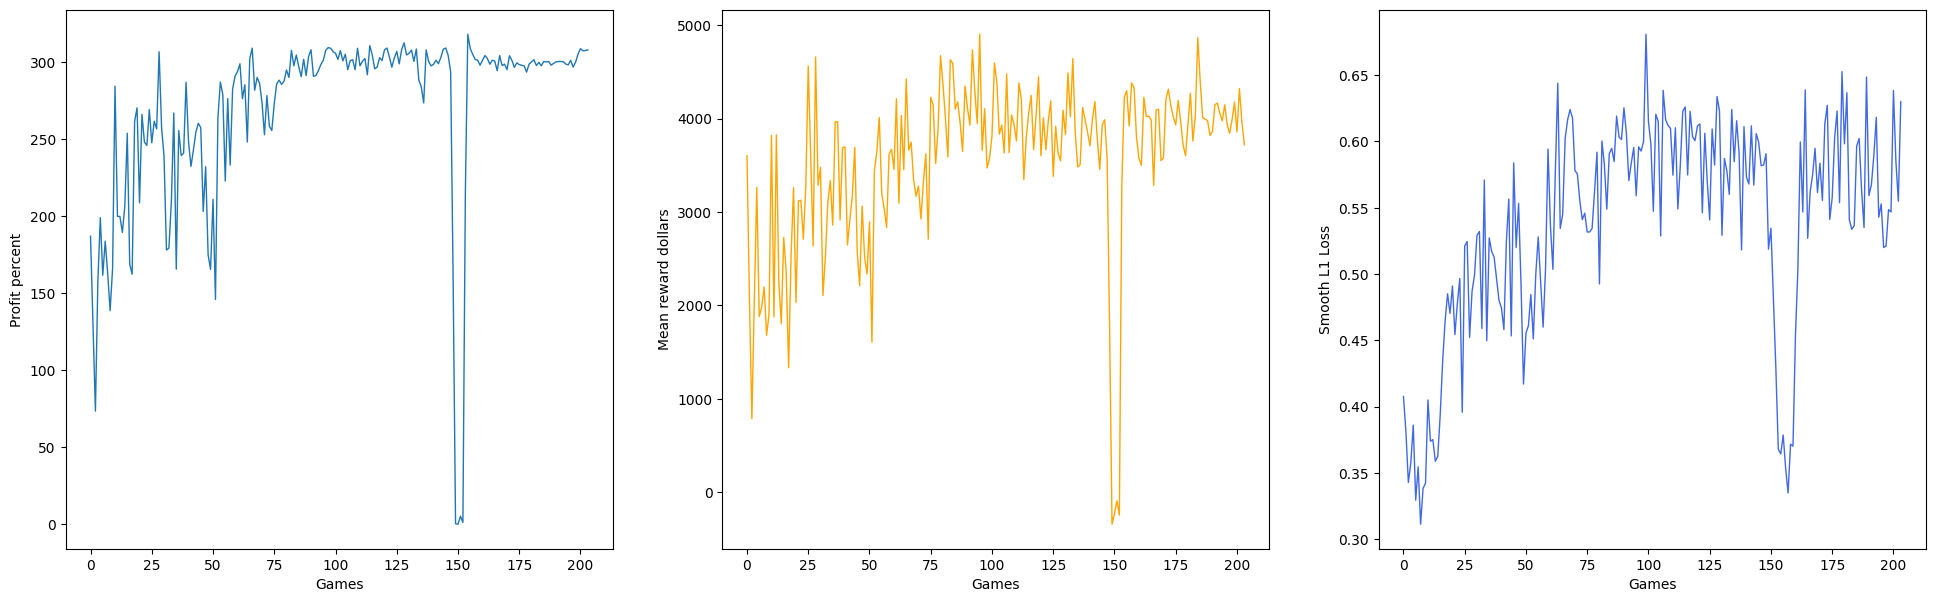

In [833]:
fig, ax=plt.subplots(1,3, figsize=(24,7))
ax[0].plot(np.array(plot_profit)*100,  linewidth=1) #profit as a percentage
ax[0].set(xlabel='Games', ylabel='Profit percent')

ax[1].plot(plot_reward, linewidth=1, color='orange')
ax[1].set(xlabel='Games', ylabel='Mean reward dollars')

ax[2].plot(plot_loss, linewidth=1, color='royalblue')
ax[2].set(xlabel='Games', ylabel='Smooth L1 Loss')

## **Visualize Actions**, **Positive: BUY, Negative: SELL**

<ipython-input-834-e173f20f7b44>:17: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  plt.annotate("Game"+str(game_i),xy=(0,60), textcoords='offset points', fontsize=30)


Text(0, 60, 'Game180')

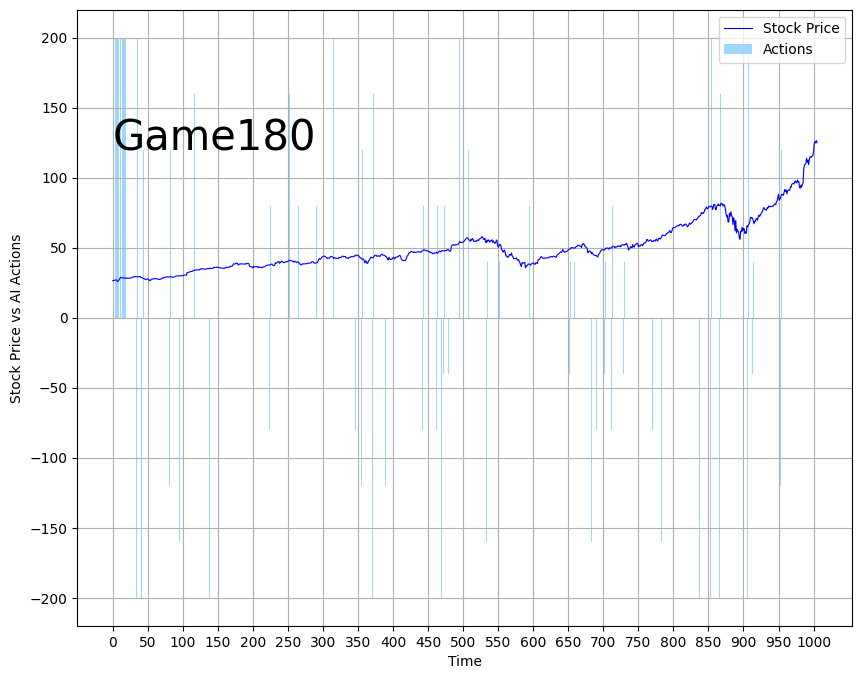

In [834]:
plt.figure(figsize=(10,8))
game_i=180 #input this to see actions in game i
game_length=stock_price_train.shape[0]-CONTEXT  #length of stock price
# np.pad(stock_price, (CONTEXT//2,CONTEXT//2),'constant', constant_values=(stock_price[0], stock_price[-1]))
#visualize actions
# plt.plot(np.array(actions[game_length*game_i:game_length*(game_i+1)])/50,linewidth=1, color='tomato', label='Actions')
plt.bar(x=np.arange(0,game_length), height=np.array(actions[game_length*game_i:game_length*(game_i+1)])/10, label='Actions', color='lightskyblue', alpha=0.8)
#plot stock price
plt.plot(stock_price_train, linewidth=0.8, color="blue", label='Stock Price')

#plt.axhline(y = 0, color = 'r', linestyle = '-')
plt.xticks(np.arange(0,stock_price_train.shape[0],50))
plt.ylabel("Stock Price vs AI Actions")
plt.xlabel("Time")
plt.grid(True)
plt.legend()
plt.annotate("Game"+str(game_i),xy=(0,60), textcoords='offset points', fontsize=30)

### **Test on unseen graph**

In [835]:
agent.n_games=10000
actions_test=[]
plot_profit_test=[]
plot_reward_test=[]
def test():
    rewards = []
    record = 0
    game = Game(w=CONTEXT, stock=stock_test, stock_price=stock_price_test, transformer_pred=transformer_pred_test)
    epoch=5000 #a very large number just to keep the game running
    for i in tqdm( range(1,epoch+1) ):
        
        state_old = agent.get_state(game)
        action = agent.get_action(state_old, game)
        actions_test.append(action)
        
        reward, done= game.play_step(action)
#--------------------------------------------------------------------------------------------------------------------
        state_new = agent.get_state(game)

        rewards.append(reward)
        profit=game.profit

        if done:
            mean_reward=np.mean(rewards)
            plot_reward_test.append(mean_reward)
            rewards=[]
            game.reset()
            agent.n_games += 1
            if profit > record:
                record = profit

            print('Game', agent.n_games,"mean Reward", round(mean_reward,2), 'Profit', round(profit*100,2) ,'Record:', round(record*100,2), "eps",agent.epsilon)

            plot_profit.append(profit)



In [836]:
test()

 14%|█▍        | 721/5000 [00:01<00:08, 518.27it/s]

Game 10001 mean Reward 2487.62 Profit 42.94 Record: 42.94 eps 6


 27%|██▋       | 1348/5000 [00:02<00:08, 417.61it/s]

Game 10002 mean Reward 1537.85 Profit 44.19 Record: 44.19 eps 6


 40%|███▉      | 1993/5000 [00:04<00:07, 389.97it/s]

Game 10003 mean Reward 2369.09 Profit 46.35 Record: 46.35 eps 6


 52%|█████▏    | 2609/5000 [00:05<00:06, 356.91it/s]

Game 10004 mean Reward 2332.26 Profit 43.86 Record: 46.35 eps 6


 65%|██████▌   | 3259/5000 [00:07<00:03, 481.87it/s]

Game 10005 mean Reward 1805.03 Profit 42.97 Record: 46.35 eps 6


 78%|███████▊  | 3912/5000 [00:08<00:02, 390.36it/s]

Game 10006 mean Reward 2361.42 Profit 43.04 Record: 46.35 eps 6


 91%|█████████ | 4545/5000 [00:10<00:01, 366.01it/s]

Game 10007 mean Reward 1595.18 Profit 43.65 Record: 46.35 eps 6


100%|██████████| 5000/5000 [00:11<00:00, 428.90it/s]


<ipython-input-838-7ea978125d5b>:14: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  plt.annotate("Game"+str(game_i),xy=(0,60), textcoords='offset points', fontsize=30)


Text(0, 60, 'Game2')

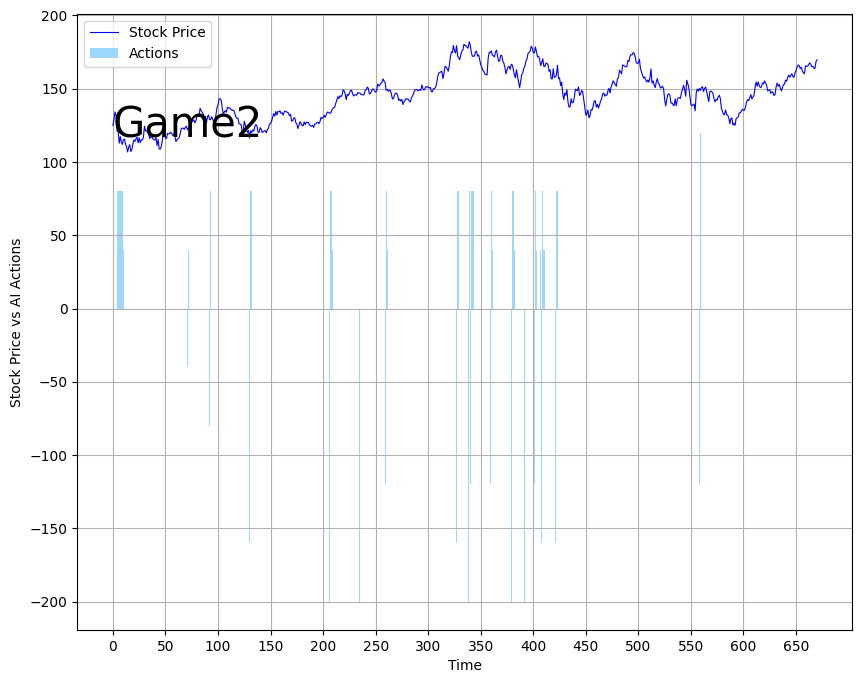

In [838]:
plt.figure(figsize=(10,8))
game_i=2 #input this to see actions in game i
game_length=stock_price_test.shape[0]-CONTEXT  #length of stock price
plt.bar(x=np.arange(0,game_length), height=np.array(actions_test[game_length*game_i:game_length*(game_i+1)])/10, label='Actions', color='lightskyblue', alpha=0.8)
#plot stock price
plt.plot(stock_price_test, linewidth=0.8, color="blue", label='Stock Price')

#plt.axhline(y = 0, color = 'r', linestyle = '-')
plt.xticks(np.arange(0,stock_price_test.shape[0],50))
plt.ylabel("Stock Price vs AI Actions")
plt.xlabel("Time")
plt.grid(True)
plt.legend()
plt.annotate("Game"+str(game_i),xy=(0,60), textcoords='offset points', fontsize=30)